In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from glob import glob

from PIL import Image
from tqdm import notebook
import pytesseract

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [3]:
def image_road(image_path) :
    img = cv2.imread(image_path)
    return img

In [4]:
def image_scale(image_path) :
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return thresh

In [5]:
def remove_horizontal(scale_image) :
    clean = scale_image.copy()
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))
    detect_horizontal = cv2.morphologyEx(scale_image, cv2.MORPH_OPEN,
                                         horizontal_kernel, iterations  = 2)
    cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts :
        cv2.drawContours(clean, [c], -1, 0, 3)
        
    return clean

In [6]:
def remove_vertical(scale_image) :
    clean = scale_image.copy()
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))
    detect_vertical = cv2.morphologyEx(scale_image, cv2.MORPH_OPEN,
                                       vertical_kernel, iterations = 2)
    cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts :
        cv2.drawContours(clean, [c], -1,  0, 3)
        
    return clean

In [7]:
def dilate_and_erode(scale_image) :
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    dilate = cv2.dilate(scale_image, kernel, anchor = (-1, -1), iterations = 5)
    erode = cv2.erode(dilate, kernel, anchor = (-1, -1), iterations = 5)
    
    cnts = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    return cnts

In [8]:
def preprocess_image(contour) :
    final_list = []
    for c in contour : 
        final_list.append(list(cv2.boundingRect(c)))
        
    final_data = pd.DataFrame()
    for i in range(len(final_list)) :
        new_row = final_list[i]
        new_row = pd.DataFrame(new_row).T
        
        final_data = pd.concat([final_data, new_row])
        
    final_data.reset_index(drop = True, inplace = True)
    final_data.columns = ['x', 'y', 'w', 'h']
    
    tmp = final_data.groupby('y').agg({'h' : 'max'})
    temp = tmp.reset_index()
    
    
    drop_list = []
    for i in range(len(temp)) :
        if i == 0 :
            continue
        if abs(temp['y'][i-1] - temp['y'][i]) <= 10 :
            if temp['h'][i-1] >= temp['h'][i] :
                drop_list.append(i)
            else :
                drop_list.append(i-1)
                
    temp = temp.drop(drop_list, axis = 0)
    temp.reset_index(drop = True, inplace = True)
    
    drop_list = []
    for i in range(len(temp)) :
        if i == 0 :
            continue
        if abs(temp['y'][i-1] - temp['y'][i]) <= 15 :
            if temp['h'][i-1] + temp['y'][i-1] >= temp['h'][i] + temp['y'][i] :
                drop_list.append(i)
            else :
                drop_list.append(i-1)
    temp = temp.drop(drop_list, axis = 0)
    temp.reset_index(drop = True, inplace = True)
    
    final = pd.merge(temp, final_data)
    return final

In [9]:
def draw_line(image, contour, data) :
    new_x_line = []
    new_y_line = []
    
    for c in contour :
        x, y, w, h = cv2.boundingRect(c)
        
        for i in range(len(data)) :
            if x == data['x'][i] and y == data['y'][i] and \
                w == data['w'][i] and h == data['h'][i] :
                area = cv2.contourArea(c)
                
                if area > 40 :
                    ROI = image[y:y+h, x:x+w]
                    ROI = cv2.GaussianBlur(ROI, (7,7), 0)
                    
                    cv2.line(image, (x-5000, y+h), (x+w+5000, y+h), (36, 255, 12), 5)
                    
    return image

In [10]:
file_list = glob('../data/pic/*.jpg')

In [11]:
img = image_road(file_list[0])
scale_image = image_scale(file_list[0])
scale_image = remove_horizontal(scale_image)
scale_image = remove_vertical(scale_image)
contour = dilate_and_erode(scale_image)
final = preprocess_image(contour)
draw_image = draw_line(img, contour, final)

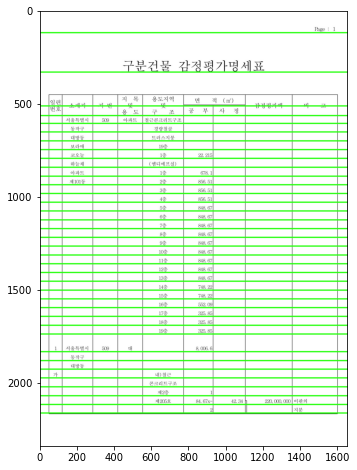

In [38]:
plt.figure(figsize = (10, 8))
plt.imshow(draw_image, cmap = 'gray')
plt.show()

In [13]:
name_list = ['1', '2', '3',' 4', '5', '6', '7', '8', '9', '10']
for i in range(len(file_list)) :
    filename = file_list[i]
    
    img = image_road(filename)
    scale_image = image_scale(filename)
    scale_image = remove_horizontal(scale_image)
    scale_image = remove_vertical(scale_image)
    contour = dilate_and_erode(scale_image)
    final = preprocess_image(contour)
    draw_image = draw_line(img, contour, final)
    
    cv2.imwrite('{}.png'.format(name_list[i]), draw_image)